Crystal Grpahs (CG) Construction

In [1]:
import csv, functools, json, warnings, re
import os, random
import numpy as np
import torch
from torch.utils.data import Dataset
from pymatgen.core import Element, Structure, Lattice
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

class GaussianDistance(object):
    def __init__(self, dmin, dmax, step, var=None):
        assert dmin < dmax
        assert dmax - dmin > step
        self.filter = np.arange(dmin, dmax + step, step)
        self.var = step if var is None else var

    def expand(self, distances):
        return np.exp(-(distances[..., np.newaxis] - self.filter) ** 2 / self.var ** 2)


class CIFData(Dataset):
    def __init__(self, id_prop_path, magmom_path, eigen_path, ofm_val_comp_path,
             max_num_nbr=12, radius=8, dmin=0, step=0.1, random_seed=123):


        # Load CSV
        with open(id_prop_path) as f:
            reader = csv.reader(f)
            self.id_prop_data = [row for row in reader]

        # Load magnetic moments
        with open(magmom_path) as f:
            self.magmom = json.load(f)

        # Load magnetic moments
        with open(eigen_path) as f:
            self.eigen1 = json.load(f)

        # Load magnetic moments
        with open(ofm_val_comp_path) as f:
            self.ofm_val_comp = json.load(f)

        random.seed(random_seed)
        random.shuffle(self.id_prop_data)

        self.gdf = GaussianDistance(dmin=dmin, dmax=radius, step=step)
        self.max_num_nbr = max_num_nbr
        self.radius = radius

    def __len__(self):
        return len(self.id_prop_data)

    def structure_from_str(self, cif_string):
        cif_lines = cif_string.strip().split('\n')

    # Parse lattice
        a, b, c = map(float, cif_lines[2].split()[2:5])
        alpha, beta, gamma = map(float, cif_lines[3].split()[1:4])

        species, coords = [], []

        reading_atoms = False
        for line in cif_lines:
            line = line.strip()
            if re.match(r'^\d+\s+\w+\s+[\d\.Ee+-]+\s+[\d\.Ee+-]+\s+[\d\.Ee+-]+', line):
                reading_atoms = True
            if not reading_atoms:
                continue
            try:
                parts = line.split()
                if len(parts) < 5:
                    continue
                sp = parts[1]
                a_frac, b_frac, c_frac = map(float, parts[2:5])
                species.append(sp)
                coords.append([a_frac, b_frac, c_frac])
            except Exception as e:
                warnings.warn(f"Skipping line due to error: {line} ({e})")
                continue

        lattice = Lattice.from_parameters(a, b, c, alpha, beta, gamma)
        return Structure(lattice, species, coords)


    def featurizer(self, element):
        min_max = [[1.00794, 244.0], [1.0, 118.0], [0.25, 2.6], [-0.72, 3.61272528]]
        lis = ['Atomic mass', 'Atomic no', 'Atomic radius', 'Electron affinity']
        ele = Element(element)
        try:
            fea = [float(str(ele.data[i]).split()[0]) for i in lis]
        except:
            fea = [ele.data['Atomic mass'], ele.data['Atomic no'],
                   ele.data['Atomic radius calculated'], ele.data['Electron affinity']]
        for i in range(4):
            fea[i] = (fea[i] - min_max[i][0]) / (min_max[i][1] - min_max[i][0])
        return fea

    @functools.lru_cache(maxsize=None)
    def __getitem__(self, idx):
        cif_id, cif_string, target = self.id_prop_data[idx]
        crystal = self.structure_from_str(cif_string)

        atom_fea = np.vstack([
            [self.magmom[site.species_string]] + self.ofm_val_comp[site.species_string]
            + self.featurizer(site.species_string)
            for site in crystal
        ])
        atom_fea = torch.Tensor(atom_fea)

        all_nbrs = crystal.get_all_neighbors(self.radius, include_index=True)
        all_nbrs = [sorted(nbrs, key=lambda x: x[1]) for nbrs in all_nbrs]
        nbr_fea_idx, nbr_fea = [], []

        for i, nbr in enumerate(all_nbrs):
            if len(nbr) < self.max_num_nbr:
                warnings.warn(f'{cif_id} atom {i} has only {len(nbr)} neighbors. Consider increasing radius.')
                nbr_fea_idx.append([x[2] for x in nbr] + [0] * (self.max_num_nbr - len(nbr)))
                nbr_fea.append([x[1] for x in nbr] + [self.radius + 1.] * (self.max_num_nbr - len(nbr)))
            else:
                nbr_fea_idx.append([x[2] for x in nbr[:self.max_num_nbr]])
                nbr_fea.append([x[1] for x in nbr[:self.max_num_nbr]])

        nbr_fea_idx = torch.LongTensor(nbr_fea_idx)
        nbr_fea = torch.Tensor(self.gdf.expand(np.array(nbr_fea)))
        target = torch.Tensor([float(target)])
        return (atom_fea, nbr_fea, nbr_fea_idx), target, cif_id



CG to Vector

In [2]:
# Add this function below your CIFData class
def graph_to_vector(atom_fea, nbr_fea):
    """
    Convert a graph's atom and neighbor features to a fixed-size vector.
    Includes mean and std pooling over atom and edge features.
    """
    atom_mean = atom_fea.mean(dim=0)
    atom_std = atom_fea.std(dim=0)
    edge_mean = nbr_fea.mean(dim=(0, 1))
    edge_std = nbr_fea.std(dim=(0, 1))

    return torch.cat([atom_mean, atom_std, edge_mean, edge_std], dim=0)  # shape: [2*D_node + 2*D_edge]

# Example usage:
dataset = CIFData(id_prop_path="my_new_data1/mn_fim.csv", magmom_path="my_new_data1/magmom.json", eigen_path="my_new_data1/eigenvalues_bulk.json",
                   ofm_val_comp_path="my_new_data1/ofm.json")
(graph_data, target, cif_id) = dataset[0]
atom_fea, nbr_fea, nbr_fea_idx = graph_data

fixed_vector = graph_to_vector(atom_fea, nbr_fea)
print("Graph vector shape:", fixed_vector.shape)
print("Graph vector:", fixed_vector)

X = []
y = []      
for (atom_fea, nbr_fea, _), target, cif_id in dataset:
    graph_vec = graph_to_vector(atom_fea, nbr_fea)
    X.append(graph_vec.numpy())  # convert tensor to numpy
    y.append(target.item())      # scalar target



Graph vector shape: torch.Size([236])
Graph vector: tensor([4.2724e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 4.0000e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 4.0000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e-01, 0.0000e+00, 0.0000e+00, 2.0000e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.8517e-01, 2.5641e-01, 4.8936e-01,
        2.4425e-01, 1.5599e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.4772e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 5.4772e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 4.4721e-01, 0.0000e+00, 0.0000e+00, 4.4721e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7514e-01, 

Dynamic Stratification of Datasets and Impementation of Random Forest (RF) with k-fold Cross Validation

Using 10 bins for stratification (min bin size: 97)

Fold 1:
  R² score   : 0.5726
  Pearson CC : 0.7586
  MAE        : 0.0137

Fold 2:
  R² score   : 0.5493
  Pearson CC : 0.7429
  MAE        : 0.0151

Fold 3:
  R² score   : 0.5541
  Pearson CC : 0.7559
  MAE        : 0.0158

Fold 4:
  R² score   : 0.4889
  Pearson CC : 0.6994
  MAE        : 0.0150

Fold 5:
  R² score   : 0.5575
  Pearson CC : 0.7563
  MAE        : 0.0145

Fold 6:
  R² score   : 0.5932
  Pearson CC : 0.7716
  MAE        : 0.0135

Fold 7:
  R² score   : 0.3569
  Pearson CC : 0.6132
  MAE        : 0.0157

Fold 8:
  R² score   : 0.5402
  Pearson CC : 0.7352
  MAE        : 0.0132

Fold 9:
  R² score   : 0.4709
  Pearson CC : 0.6897
  MAE        : 0.0152

Fold 10:
  R² score   : 0.6348
  Pearson CC : 0.8093
  MAE        : 0.0140

=== Stratified 5-Fold CV Summary ===
Avg R²   : 0.5318 ± 0.0733
Avg CC   : 0.7332 ± 0.0515
Avg MAE  : 0.0146 ± 0.0009


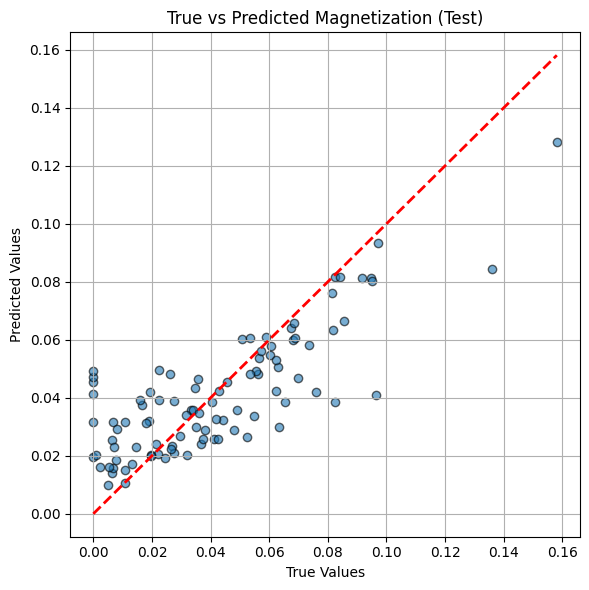

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import pearsonr
import numpy as np

def make_safe_stratification_bins(y, min_per_bin=30, max_bins=10):
    """
    Dynamically bin continuous target into bins with at least min_per_bin samples.
    Uses quantile-based binning.
    """
    for n_bins in range(max_bins, 1, -1):
        try:
            discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
            y_binned = discretizer.fit_transform(y.reshape(-1, 1)).astype(int).ravel()
            _, counts = np.unique(y_binned, return_counts=True)
            if np.min(counts) >= min_per_bin:
                print(f"Using {n_bins} bins for stratification (min bin size: {np.min(counts)})")
                return y_binned
        except Exception:
            continue
    raise ValueError("Failed to create stratification bins with sufficient support.")

# Prepare data
X = np.array(X)
y = np.array(y)

# Make stratification bins
y_binned = make_safe_stratification_bins(y)

# Set up stratified 5-fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

r2_scores, cc_scores, mae_scores = [], [], []
fold = 1

for train_idx, test_idx in skf.split(X, y_binned):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    cc, _ = pearsonr(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    r2_scores.append(r2)
    cc_scores.append(cc)
    mae_scores.append(mae)

    print(f"\nFold {fold}:")
    print(f"  R² score   : {r2:.4f}")
    print(f"  Pearson CC : {cc:.4f}")
    print(f"  MAE        : {mae:.4f}")
    fold += 1

# Final CV summary
print("\n=== Stratified 5-Fold CV Summary ===")
print(f"Avg R²   : {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
print(f"Avg CC   : {np.mean(cc_scores):.4f} ± {np.std(cc_scores):.4f}")
print(f"Avg MAE  : {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.title('True vs Predicted Magnetization (Test)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.tight_layout()
plt.show()


PCA and t-SNE


=== PCA Explained Variance ===
PC1: 33.17%
PC2: 16.65%


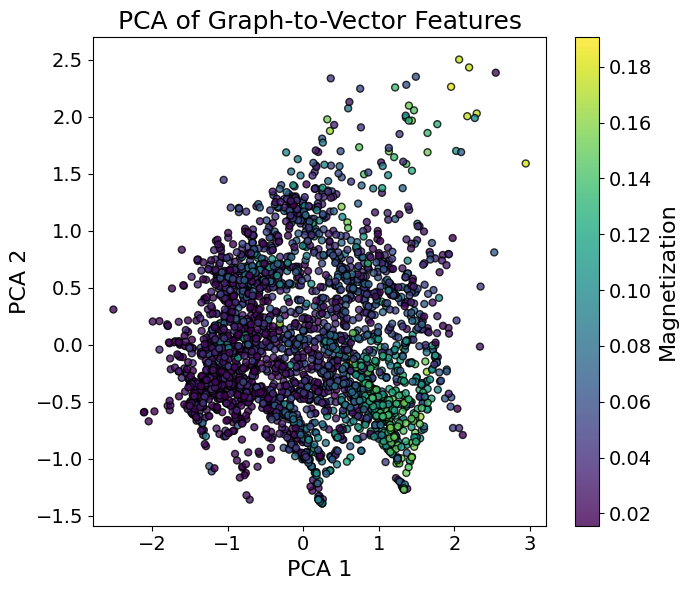

c:\Users\Sand\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


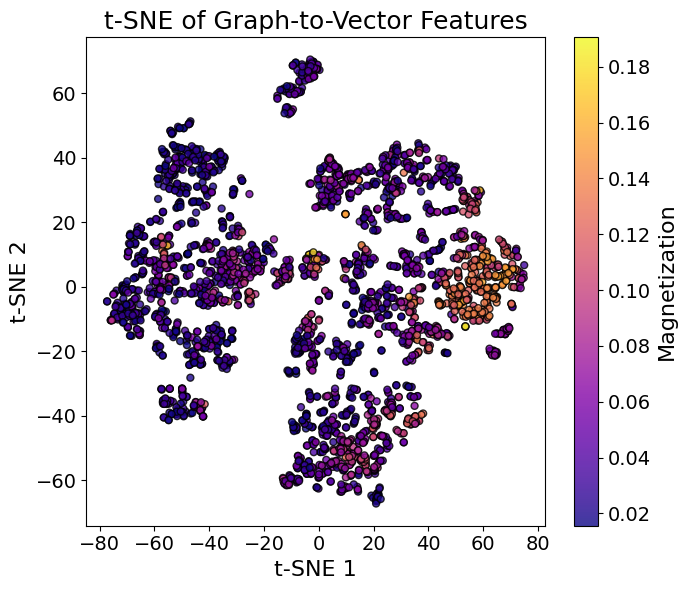

In [4]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

# --- Convert data ---
X_arr = np.array(X)
y_arr = np.array(y)

# ===========================
# 1. PCA Analysis
# ===========================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_arr)

print("\n=== PCA Explained Variance ===")
print(f"PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")

# ===========================
# 1. PCA Analysis
# ===========================
plt.figure(figsize=(7,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y_arr, cmap='viridis', s=25, alpha=0.8, edgecolor='k')

cbar = plt.colorbar(scatter)
cbar.set_label('Magnetization', fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.xlabel("PCA 1", fontsize=16)
plt.ylabel("PCA 2", fontsize=16)
plt.title("PCA of Graph-to-Vector Features", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()


# ===========================
# 2. t-SNE Analysis
# ===========================
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_arr)

plt.figure(figsize=(7,6))
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y_arr, cmap='plasma', s=25, alpha=0.8, edgecolor='k')

cbar = plt.colorbar(scatter)
cbar.set_label('Magnetization', fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.xlabel("t-SNE 1", fontsize=16)
plt.ylabel("t-SNE 2", fontsize=16)
plt.title("t-SNE of Graph-to-Vector Features", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()



=== PCA Explained Variance ===
PC1: 41.29%
PC2: 10.61%


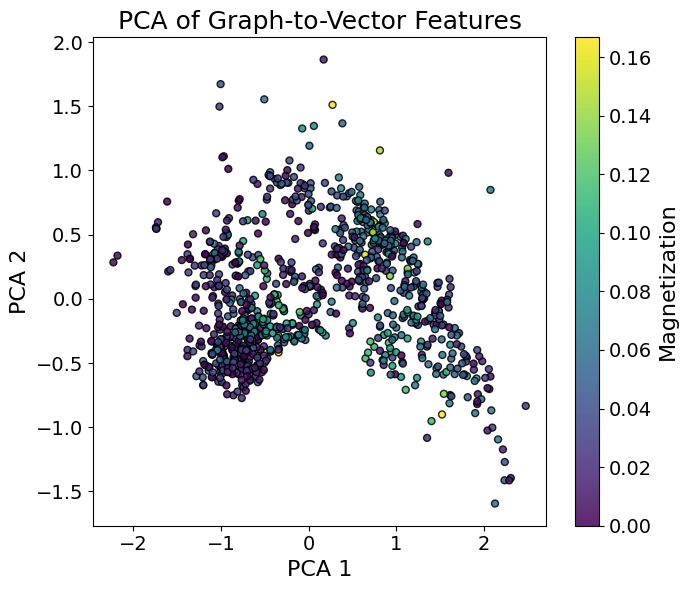

c:\Users\Sand\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


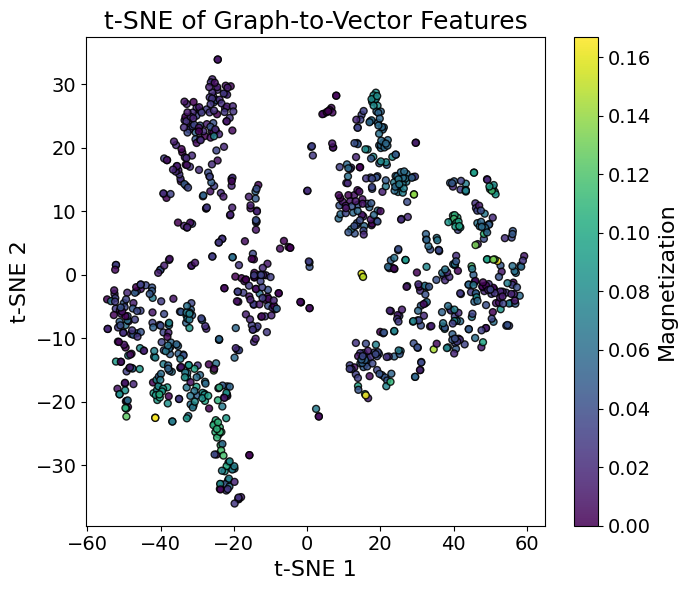

In [4]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Convert data ---
X_arr = np.array(X)
y_arr = np.array(y)

# Set common colour limits for PCA and t-SNE
vmin, vmax = y_arr.min(), y_arr.max()

# ===========================
# 1. PCA Analysis
# ===========================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_arr)

print("\n=== PCA Explained Variance ===")
print(f"PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")

plt.figure(figsize=(7,6))
scatter = plt.scatter(
    X_pca[:,0], X_pca[:,1],
    c=y_arr, cmap='viridis',
    vmin=vmin, vmax=vmax,       # <-- fixes incorrect extra colour levels
    s=25, alpha=0.85, edgecolor='k'
)

cbar = plt.colorbar(scatter)
cbar.set_label('Magnetization', fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.xlabel("PCA 1", fontsize=16)
plt.ylabel("PCA 2", fontsize=16)
plt.title("PCA of Graph-to-Vector Features", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()


# ===========================
# 2. t-SNE Analysis
# ===========================
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=1000,
    random_state=42
)
X_tsne = tsne.fit_transform(X_arr)

plt.figure(figsize=(7,6))
scatter = plt.scatter(
    X_tsne[:,0], X_tsne[:,1],
    c=y_arr, cmap='viridis',    # <-- SAME COLOUR MAP AS PCA
    vmin=vmin, vmax=vmax,       # <-- ensures identical scaling
    s=25, alpha=0.85, edgecolor='k'
)

cbar = plt.colorbar(scatter)
cbar.set_label('Magnetization', fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.xlabel("t-SNE 1", fontsize=16)
plt.ylabel("t-SNE 2", fontsize=16)
plt.title("t-SNE of Graph-to-Vector Features", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()


RF with 60-20-20 train-val-test datasplit with stratified bins

✅ Using 10 bins for stratification (min bin size: 294)
Train: 2355, Val: 294, Test: 295

=== Results ===
Validation -> R²: 0.7627, CC: 0.8775, MAE: 0.0089
Test       -> R²: 0.8108, CC: 0.9029, MAE: 0.0092


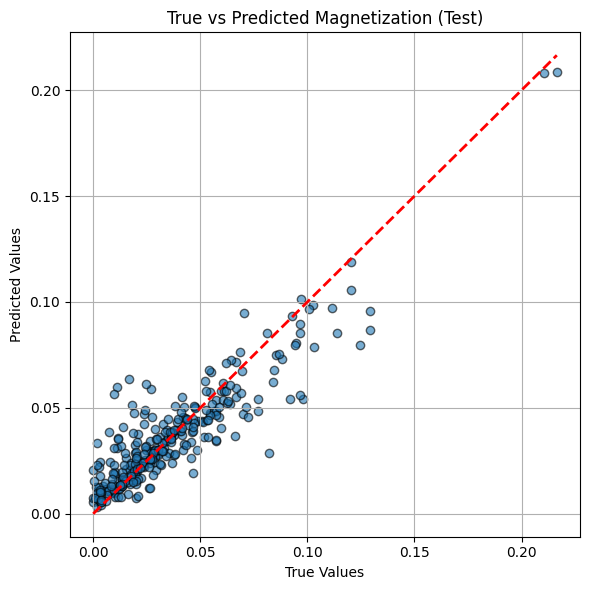

In [7]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt

# --- Helper to create safe stratification bins ---
def make_safe_stratification_bins(y, min_per_bin=30, max_bins=10):
    """
    Bin continuous target values for stratification.
    Reduces bins until each has at least min_per_bin samples.
    """
    for n_bins in range(max_bins, 1, -1):
        try:
            discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
            y_binned = discretizer.fit_transform(y.reshape(-1, 1)).astype(int).ravel()
            _, counts = np.unique(y_binned, return_counts=True)
            if np.min(counts) >= min_per_bin:
                print(f"✅ Using {n_bins} bins for stratification (min bin size: {np.min(counts)})")
                return y_binned
        except:
            continue
    raise ValueError("❌ Cannot safely bin targets for stratification")

# --- Convert to NumPy arrays ---
X = np.array(X)
y = np.array(y)

# --- Create stratification bins ---
y_binned = make_safe_stratification_bins(y)

# --- First split: 60% train, 40% temp ---
X_train, X_temp, y_train, y_temp, yb_train, yb_temp = train_test_split(
    X, y, y_binned, test_size=0.2, random_state=42, stratify=y_binned
)

# --- Second split: 20% val, 20% test ---
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=yb_temp
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# --- Train model ---
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# --- Validation evaluation ---
y_val_pred = model.predict(X_val)
r2_val = r2_score(y_val, y_val_pred)
cc_val, _ = pearsonr(y_val, y_val_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)

# --- Test evaluation ---
y_test_pred = model.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
cc_test, _ = pearsonr(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print("\n=== Results ===")
print(f"Validation -> R²: {r2_val:.4f}, CC: {cc_val:.4f}, MAE: {mae_val:.4f}")
print(f"Test       -> R²: {r2_test:.4f}, CC: {cc_test:.4f}, MAE: {mae_test:.4f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.6, edgecolors='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.title('True vs Predicted Magnetization (Test)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.tight_layout()
plt.show()



RF with 60-20-20 train-val-test datasplit

Train: 2400, Val: 300, Test: 301

=== Results ===
Validation -> R²: 0.2199, CC: 0.4715, MAE: 0.0016
Test       -> R²: 0.2914, CC: 0.5449, MAE: 0.0015


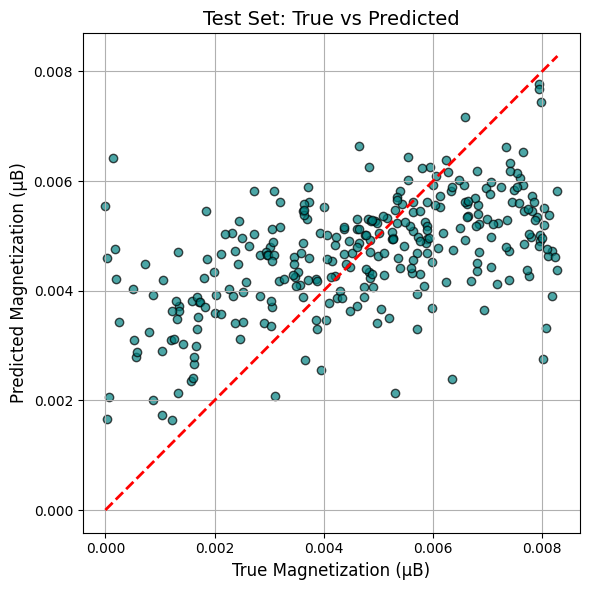

In [5]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# --- First split: 60% train, 40% temp ---
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Second split: 20% val, 20% test ---
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# --- Train model ---
model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

# --- Validation evaluation ---
y_val_pred = model.predict(X_val)
r2_val = r2_score(y_val, y_val_pred)
cc_val, _ = pearsonr(y_val, y_val_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)

# --- Test evaluation ---
y_test_pred = model.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
cc_test, _ = pearsonr(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print("\n=== Results ===")
print(f"Validation -> R²: {r2_val:.4f}, CC: {cc_val:.4f}, MAE: {mae_val:.4f}")
print(f"Test       -> R²: {r2_test:.4f}, CC: {cc_test:.4f}, MAE: {mae_test:.4f}")

# --- Scatter plot (Test set) ---
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.7, edgecolor='k', color='teal')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.xlabel('True Magnetization (μB)', fontsize=12)
plt.ylabel('Predicted Magnetization (μB)', fontsize=12)
plt.title('Test Set: True vs Predicted', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


✅ Using 10 bins for stratification (min bin size: 300)
Train: 1800, Val: 600, Test: 600

=== Results ===
Validation -> R²: 0.8240, CC: 0.9083, MAE: 0.0107
Test       -> R²: 0.7880, CC: 0.8878, MAE: 0.0114


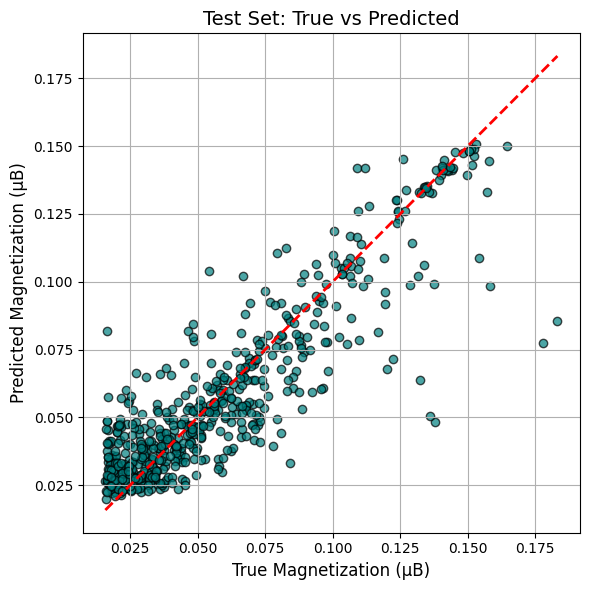